In [1]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy import loadtxt
import tensorflow.keras
from PIL import Image, ImageOps
%matplotlib inline

In [2]:
image_size = 256
batch_size = 32

In [3]:
# folders with train dir & val dir
train_dir = 'tomato/train/'
val_dir = 'tomato/val/'
test_dir = 'tomato/test/'
input_shape = (image_size, image_size, 3)
img=[image_size, image_size]

In [10]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                              samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = True, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.2, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.2)

In [11]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 14821 images belonging to 10 classes.


In [6]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 1825 images belonging to 10 classes.


In [7]:
val_datagen = ImageDataGenerator(rescale=1. / 255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')

Found 1812 images belonging to 10 classes.


In [8]:
train_generator.class_indices

{'Tomato___Bacterial_spot': 0,
 'Tomato___Early_blight': 1,
 'Tomato___Late_blight': 2,
 'Tomato___Leaf_Mold': 3,
 'Tomato___Septoria_leaf_spot': 4,
 'Tomato___Spider_mites Two-spotted_spider_mite': 5,
 'Tomato___Target_Spot': 6,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato___Tomato_mosaic_virus': 8,
 'Tomato___healthy': 9}

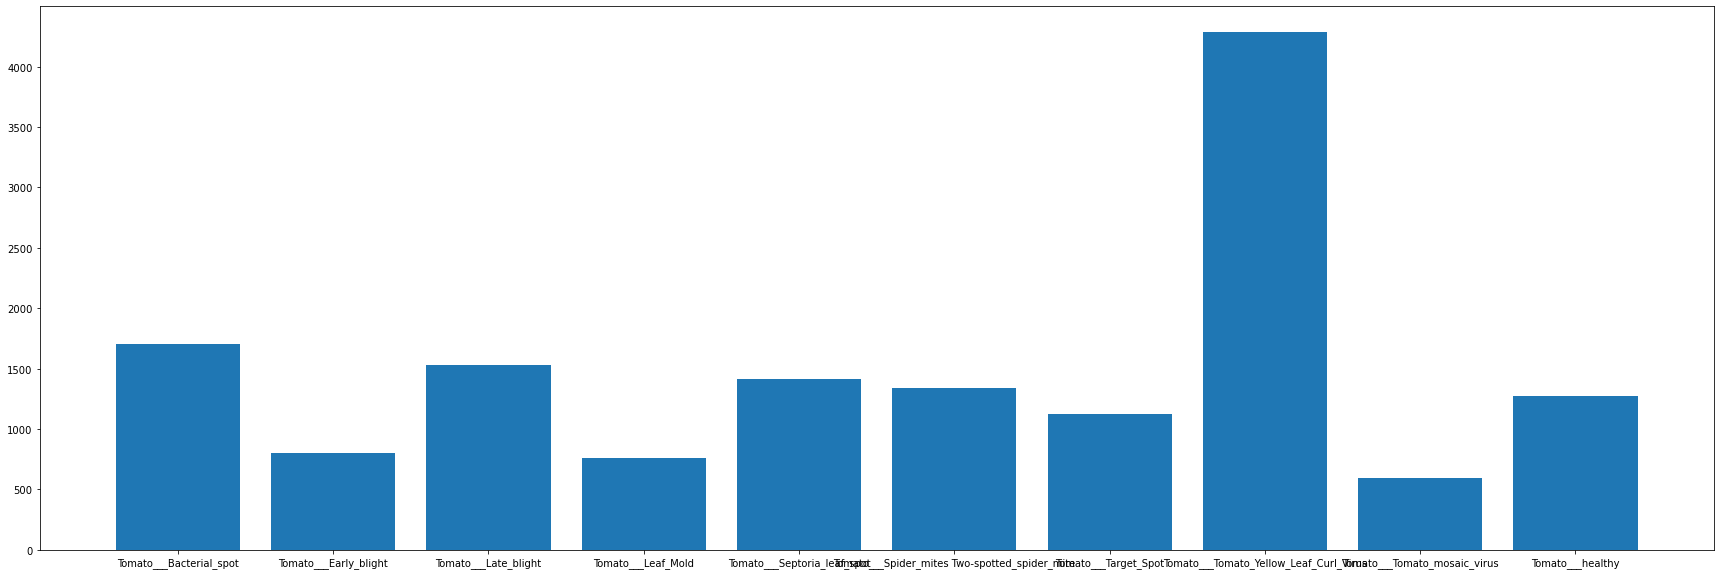

In [12]:
from sklearn.utils.class_weight import compute_class_weight
cls_train = train_generator.classes
from collections import OrderedDict
classes = list(train_generator.class_indices.keys())
num_values = []
unique, counts = np.unique(cls_train, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
for i in range(10):
    num_values.append(valdict[i])
plt.figure(figsize=(30,10))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.show()

[1701  800 1527  761 1416 1340 1123 4285  596 1272]


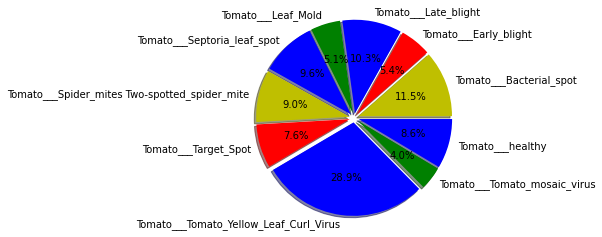

In [13]:
import matplotlib.pyplot as plt
goal_types = list(train_generator.class_indices.keys())
unique, counts = np.unique(cls_train, return_counts=True)
goals = (counts)
print(counts)
colors = ['y','r','b','g','b','y','r','b','g','b']
plt.pie(goals, labels = goal_types, colors=colors ,shadow = True, explode = (0.05, 0.05, 0.05, 0.05, 0.05,0.05, 0.05, 0.05, 0.05, 0.05), autopct = '%1.1f%%')
plt.axis('equal')
plt.show()

In [14]:
pretrained_model = InceptionV3(input_shape=img+[3],weights='imagenet', include_top=False)
pretrained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [15]:
for layer in pretrained_model.layers:
    layer.trainable = False

In [ ]:
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = Activation('relu')(x)
predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=predictions)